# Labels Addition

Purpose of this notebook as to add already classified labels
to the dataset. This has been done
http://physics.muni.cz/~ssa/archive/.

## Load All Data

In [1]:
import pickle
import os

In [2]:
# load the data
data_filename = 'ondrejov-halpha.pickle'
with open(os.path.join('data', data_filename), 'rb') as f:
    spectra = pickle.load(f)

## Load Labeled Data

In [3]:
def gen_fits_paths(path):
    """Returns a generator of paths to fits files."""
    return (os.path.join(dirpath, filename)
            for dirpath, _, filenames in os.walk(path)
            for filename in filenames
            if filename.endswith('.fits'))

In [4]:
def get_fits_name(path):
    return os.path.splitext(os.path.split(path)[1])[0]

In [5]:
import re
import astropy.io.fits

In [6]:
pattern = re.compile('/(\d+)/')
def fits_data(path):
    with astropy.io.fits.open(path) as hdulist:
        # need to copy the data else it file pointer
        # won't be realesed and exception would be raised
        data = hdulist[1].data
    return {
        'wavelen': data['WAVE'],
        'norm_flux': data['FLUX'],
        'label': int(pattern.search(path).group(1)) - 1
    }

In [7]:
labeled_spectra = {
    get_fits_name(path): fits_data(path)
    for path in gen_fits_paths('labeled-data/archive_1_5/')
}

## Identify the Intersection

In [8]:
# find intersection of labeled and not labeled data
intersection = set(labeled_spectra) & set(spectra)
len(labeled_spectra), len(intersection)

(1726, 1722)

In [9]:
# these are not in intersection
difference = set(labeled_spectra) - set(spectra)
difference

{'400norm', 'pi240043', 'test1', 'test2'}

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

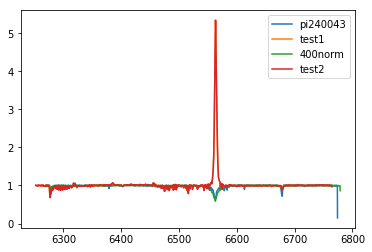

In [11]:
for spectrum in difference:
    plt.plot(
        labeled_spectra[spectrum]['wavelen'],
        labeled_spectra[spectrum]['norm_flux'],
        label=spectrum,
    )
plt.legend()

## Add Labels

In [12]:
for spectrum, data in spectra.items():
    if spectrum in labeled_spectra:
        data['label'] = labeled_spectra[spectrum]['label']
    else:
        data['label'] = -1

## Visualization

In [13]:
def spectra_with_label(label, spectra=spectra):
    return [
        spectrum
        for spectrum, data in spectra.items()
        if data['label'] == label
    ]

classes = list(map(spectra_with_label, range(5)))
# number of spectra in each class
list(map(len, classes))

[176, 172, 1186, 56, 132]

In [14]:
import random

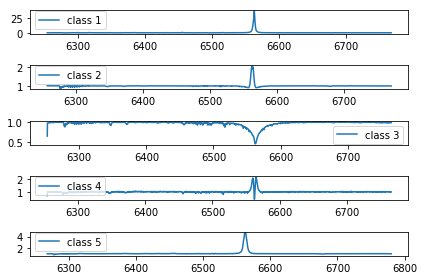

In [15]:
def plot_spectrum(spectrum, label):
    plt.plot(
        spectrum['wavelen'],
        spectrum['norm_flux'],
        label=label
    )
    plt.legend()

for i in range(5):
    plt.subplot(5, 1, i + 1)
    plot_spectrum(
        spectra[random.choice(classes[i])],
        'class {}'.format(i + 1)
    )
plt.tight_layout()

## Save the Labeled Data

In [16]:
# serialize the object for later use
pickle_filename = 'ondrejov-halpha-labeled.pickle'
with open(os.path.join('data', pickle_filename), 'wb') as f:
    pickle.dump(spectra, f)